# MCMC ベースで再現してみる

解析的に求めたが、MCMC ベースで解を求めてみる。

# housekeeping

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import scipy.stats as st

from dataclasses import dataclass
from typing import List
from scipy.stats import bernoulli

RANDOM_SEED = 1013
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")
plotting_defaults = dict(
    bins=50,
    kind="hist",
    textsize=10,
    hdi_prob = 0.89
)

# データ読み込み

In [2]:
variables = ['treatment', 'age', 'education', 'Black', 'Hispanic', 'married', 'nodegree', 'RE74', 'RE75', 'RE78']
types = [int, float, float, int, int, int, int, float, float, float]
dtypes = dict(zip(variables, types))

df_c = pd.read_table('./data/nswre74_control.txt', header=None, names=variables, sep='  ', dtype=dtypes)
df_t = pd.read_table('./data/nswre74_treated.txt', header=None, names=variables, sep='  ', dtype=dtypes)

df = pd.concat([df_c, df_t], ignore_index=True)
df.info()

/var/folders/ng/b98db55j0msdb5ddc0lr6sh40000gn/T/ipykernel_27725/602400671.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df_c = pd.read_table('./data/nswre74_control.txt', header=None, names=variables, sep='  ', dtype=dtypes)
/var/folders/ng/b98db55j0msdb5ddc0lr6sh40000gn/T/ipykernel_27725/602400671.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df_t = pd.read_table('./data/nswre74_treated.txt', header=None, names=variables, sep='  ', dtype=dtypes)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 445 entries, 0 to 444
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   treatment  445 non-null    int64  
 1   age        445 non-null    float64
 2   education  445 non-null    float64
 3   Black      445 non-null    int64  
 4   Hispanic   445 non-null    int64  
 5   married    445 non-null    int64  
 6   nodegree   445 non-null    int64  
 7   RE74       445 non-null    float64
 8   RE75       445 non-null    float64
 9   RE78       445 non-null    float64
dtypes: float64(5), int64(5)
memory usage: 34.9 KB


# PATE を求める

$$
\begin{align}
y_i &\sim \mathcal{N}(\tau_{1}, \sigma_1) \quad (\mathrm{if \: treatment==1})\\
&\sim \mathcal{N}(\tau_{0}, \sigma_0) \quad (\mathrm{if \: treatment==0})
\end{align}
$$

In [3]:
treatment = df['treatment']
COORDS = {
    'N': df['treatment'],
    'PO': np.array([0,1])
    }
with pm.Model(coords=COORDS) as nsw:
    # 事前分布
    tau = pm.Normal('tau', 0, 10000, shape=2)
    sigma = pm.HalfCauchy('sigma', 10000, shape=2)

    # y
    y = pm.Normal('income', mu=tau[treatment], sigma=sigma[treatment], observed=df['RE78'].values, dims='N')
    tau_difference = pm.Deterministic('PATE', tau[1]-tau[0])

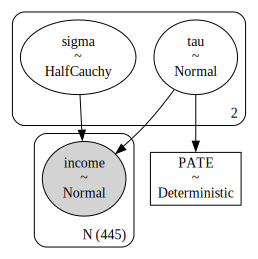

In [4]:
pm.model_to_graphviz(nsw)

In [5]:
with nsw:
    trace = pm.sample(draws=2000, tune=1000, chains=4, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [tau, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 37 seconds.


/var/folders/ng/b98db55j0msdb5ddc0lr6sh40000gn/T/ipykernel_27725/923752949.py:2: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


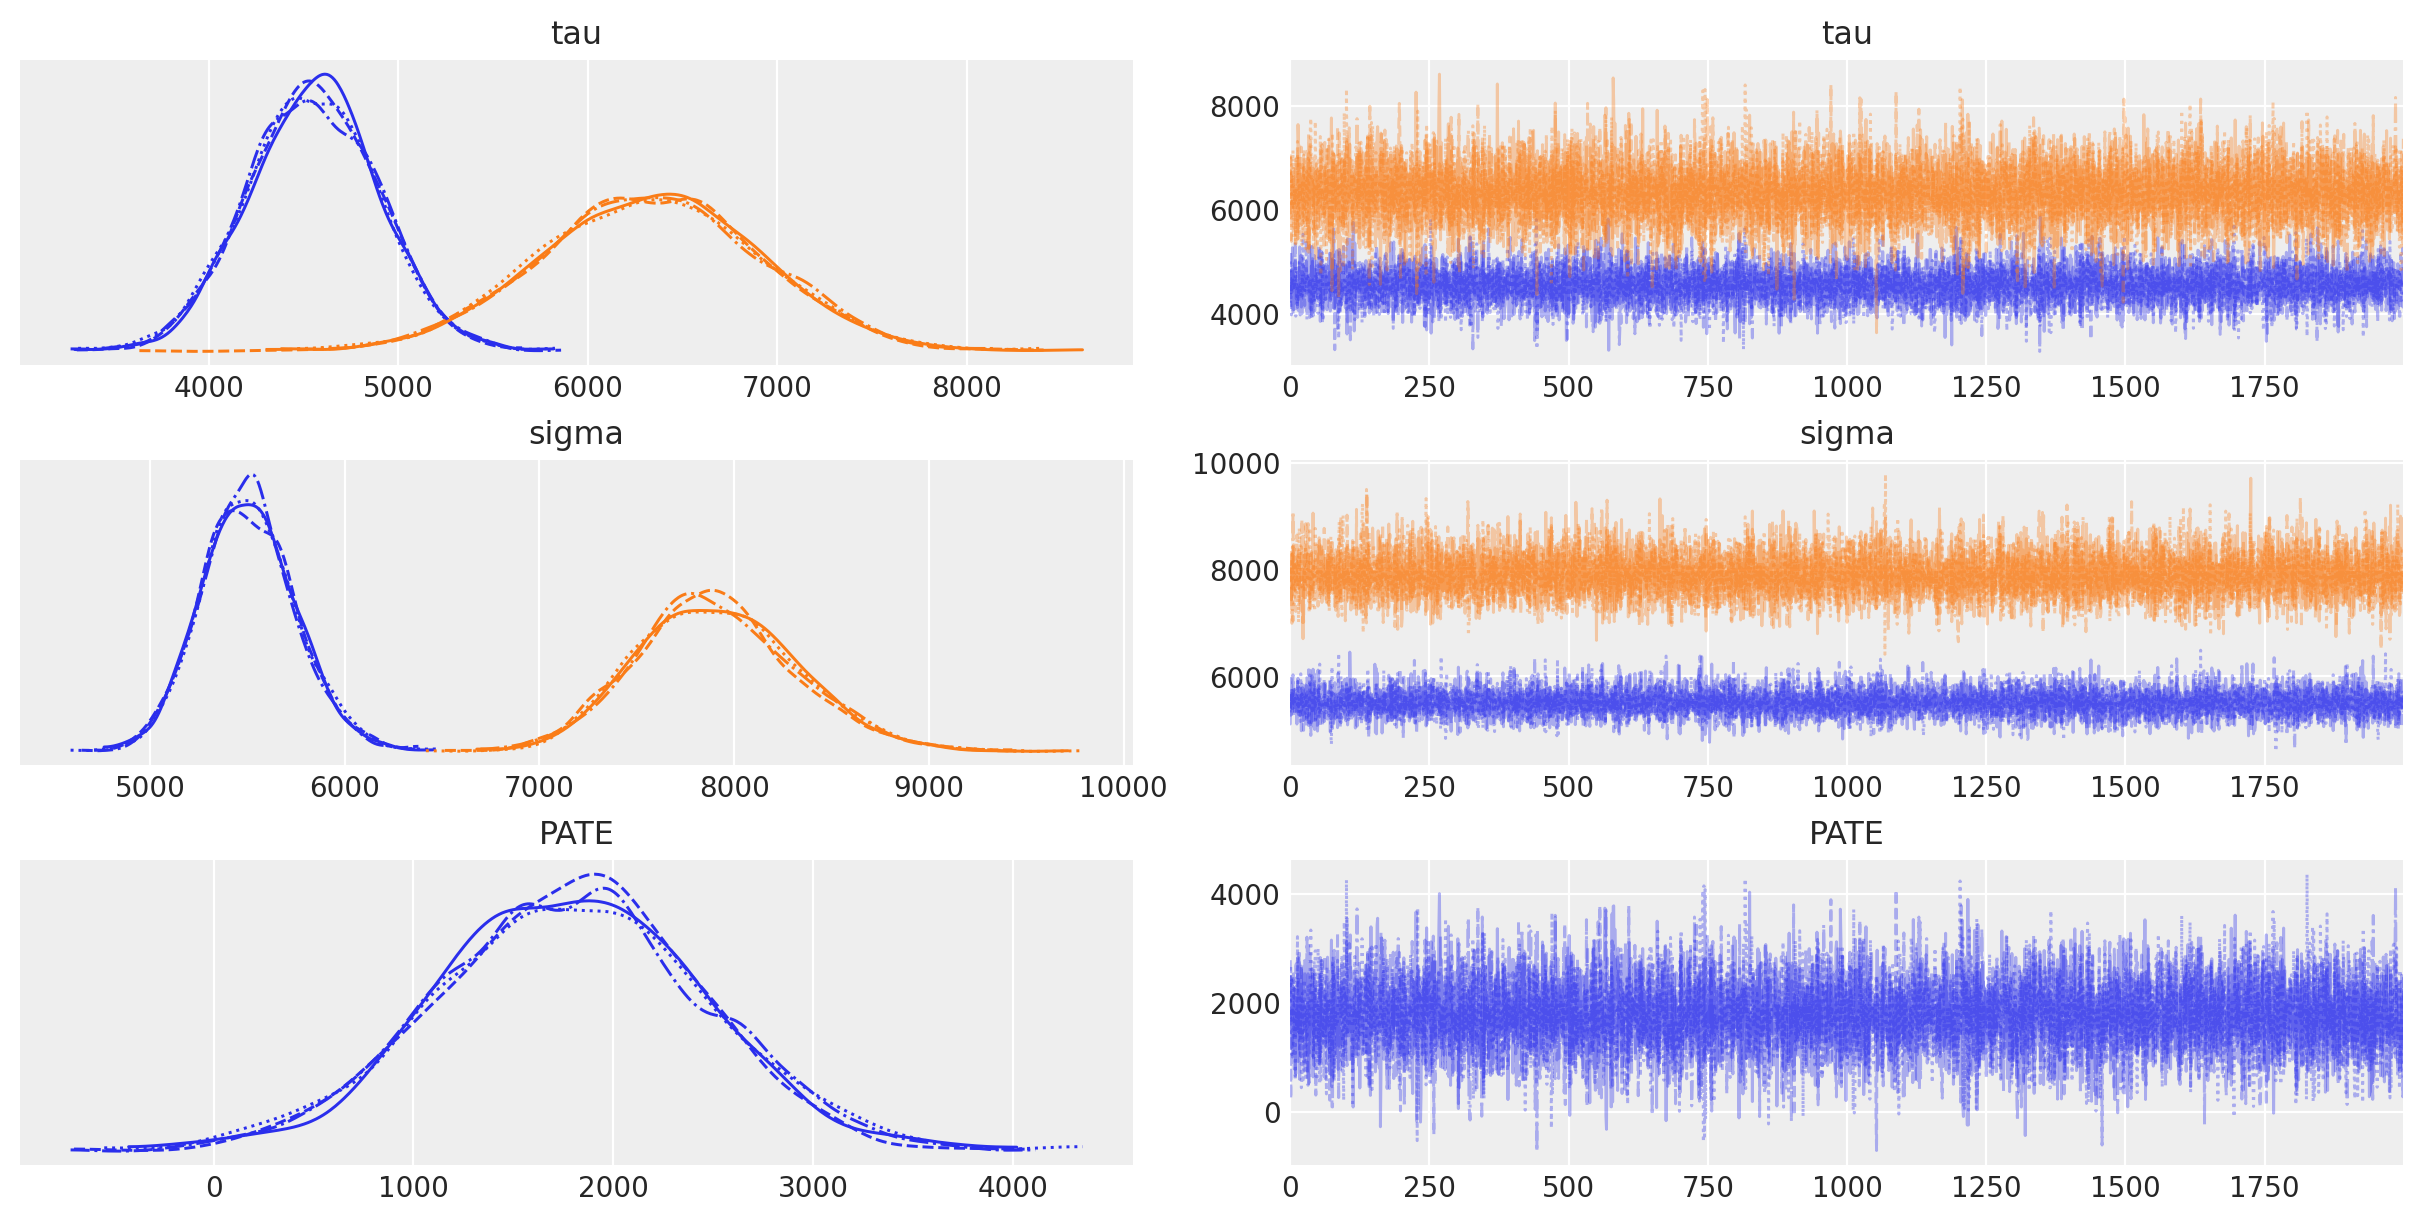

In [6]:
az.plot_trace(trace)
plt.tight_layout()

In [7]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
tau[0],4548.547,345.370,3910.316,5191.326,3.234,2.309,11403.0,6122.0,1.0
tau[1],6329.057,585.442,5238.514,7403.670,5.281,3.745,12355.0,6374.0,1.0
sigma[0],5505.591,242.952,5055.852,5965.272,2.233,1.588,11962.0,6607.0,1.0
sigma[1],7909.669,409.661,7149.516,8671.587,3.772,2.711,12294.0,6310.0,1.0
PATE,1780.510,676.719,478.125,3022.013,6.034,4.557,12584.0,6205.0,1.0


# 別のモデルで比較する

In [8]:
treatment = df['treatment']
COORDS = {'N': df['treatment']}

with pm.Model(coords=COORDS) as nsw_another:
    # 事前分布
    tau = pm.HalfNormal('tau', sigma=10000., shape=2)
    sigma = pm.HalfCauchy('sigma', 10000, shape=2)

    # y
    y = pm.Normal('income', mu=tau[treatment], sigma=sigma[treatment], observed=df['RE78'].values, dims='N')
    tau_difference = pm.Deterministic('PATE', tau[1]-tau[0])

In [9]:
with nsw_another:
    trace_another = pm.sample(draws=2000, tune=1000, chains=4, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [tau, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 30 seconds.


/var/folders/ng/b98db55j0msdb5ddc0lr6sh40000gn/T/ipykernel_27725/1457509212.py:2: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


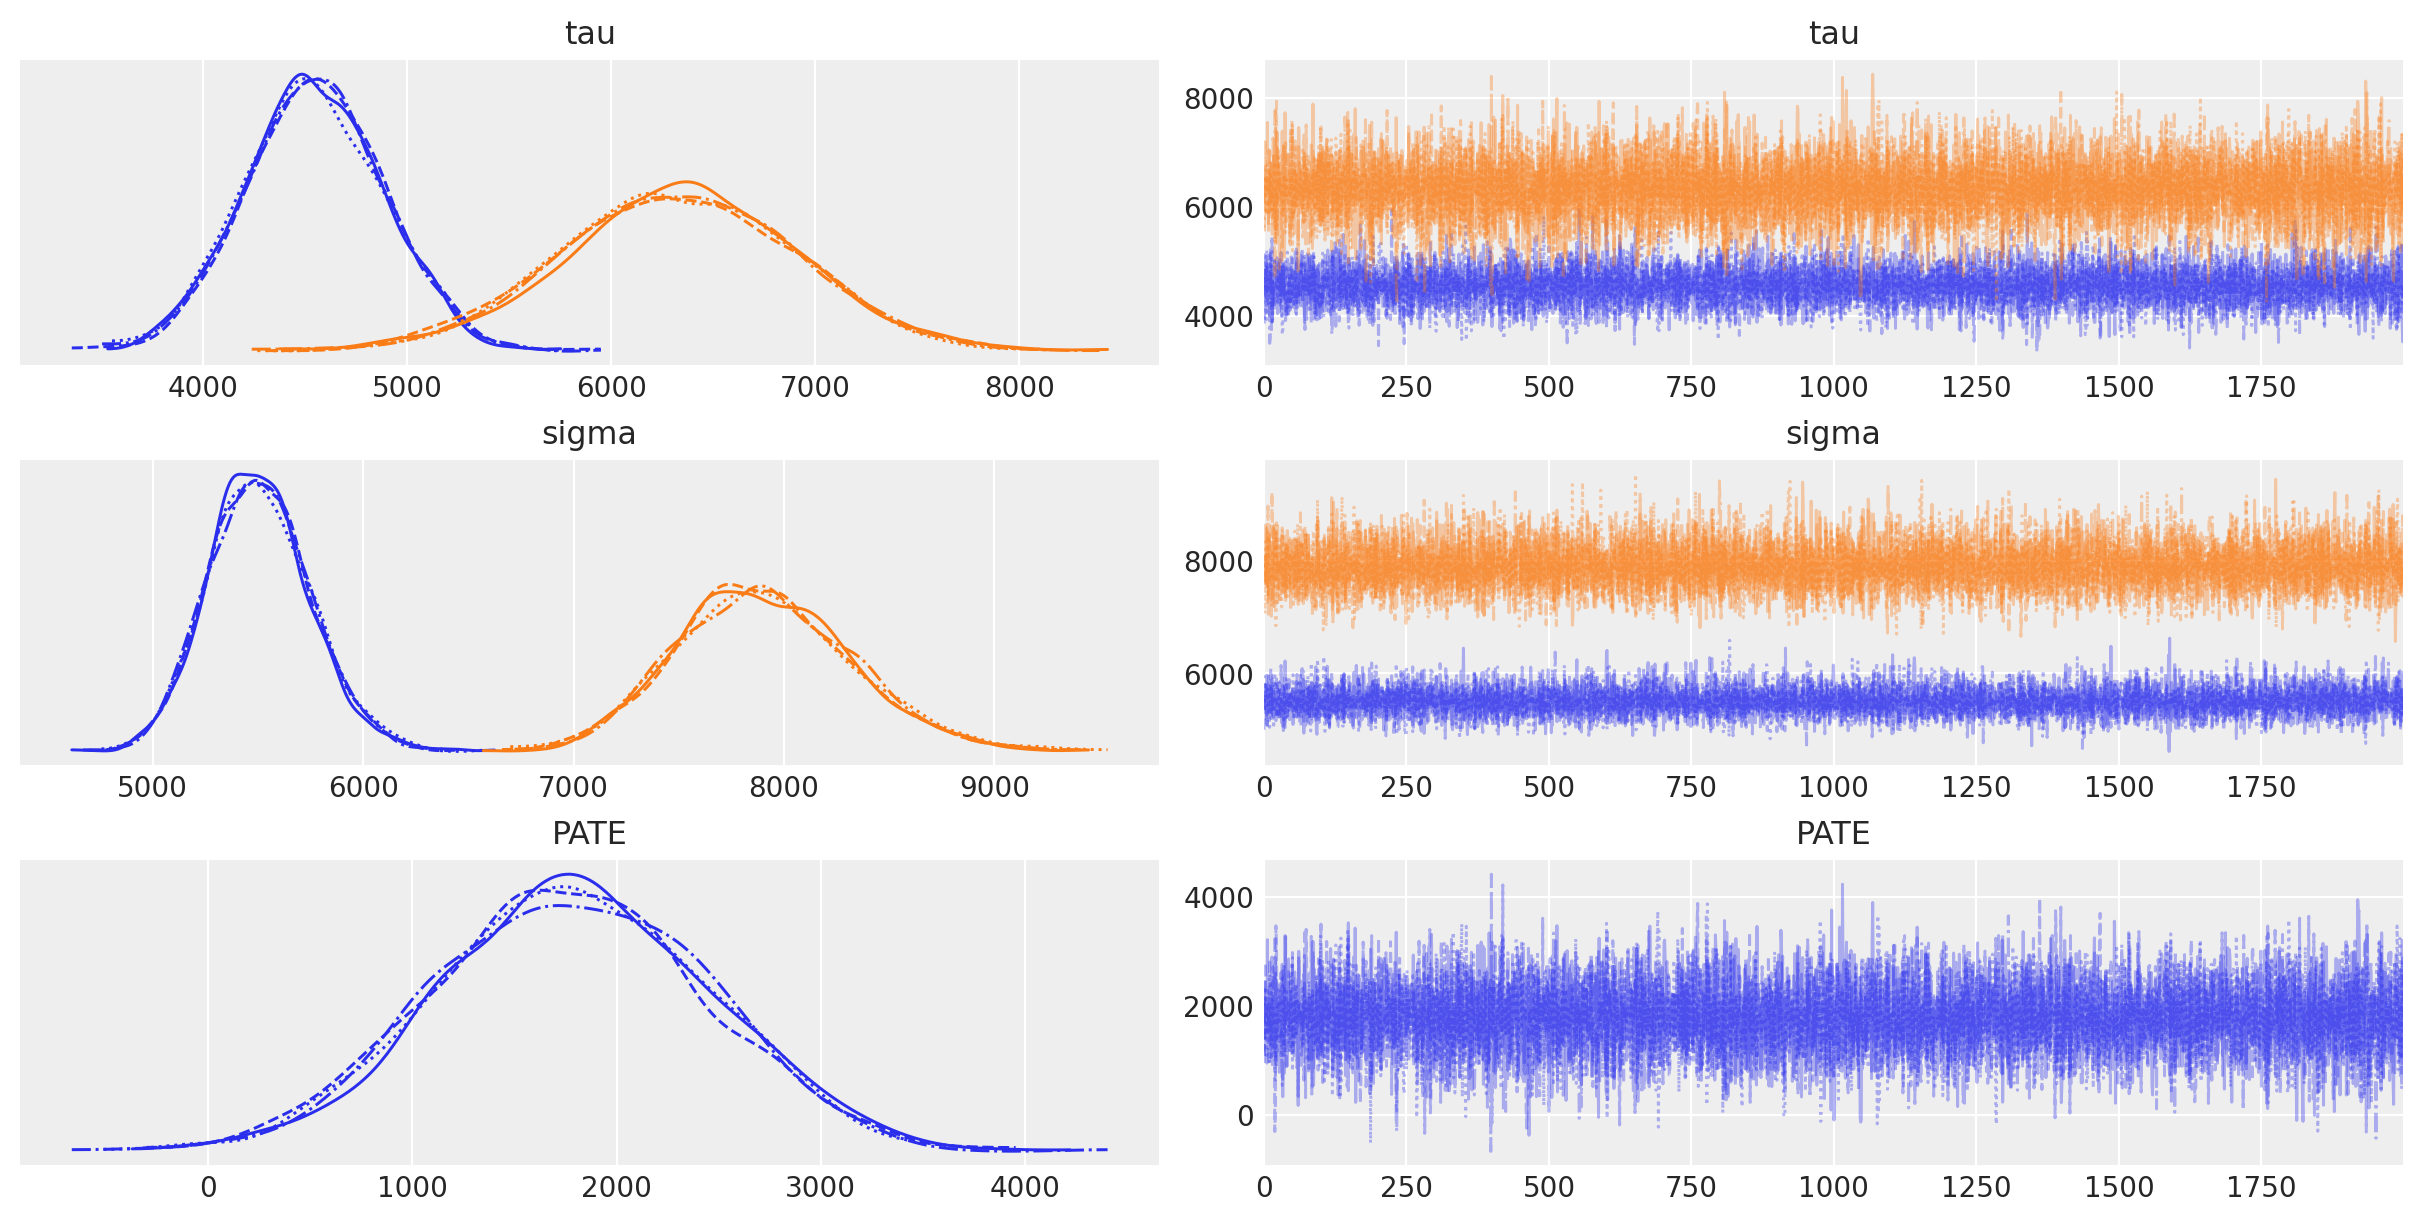

In [10]:
az.plot_trace(trace_another)
plt.tight_layout()

In [11]:
az.summary(trace_another)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
tau[0],4546.210,341.265,3933.402,5202.014,3.498,2.473,9516.0,6022.0,1.0
tau[1],6328.817,577.775,5231.134,7393.541,5.515,3.900,11115.0,5826.0,1.0
sigma[0],5508.077,243.483,5053.468,5968.311,2.305,1.646,11448.0,6697.0,1.0
sigma[1],7902.930,415.069,7141.469,8681.278,3.653,2.595,12940.0,6515.0,1.0
PATE,1782.607,667.338,559.827,3034.676,6.399,4.664,10864.0,6128.0,1.0


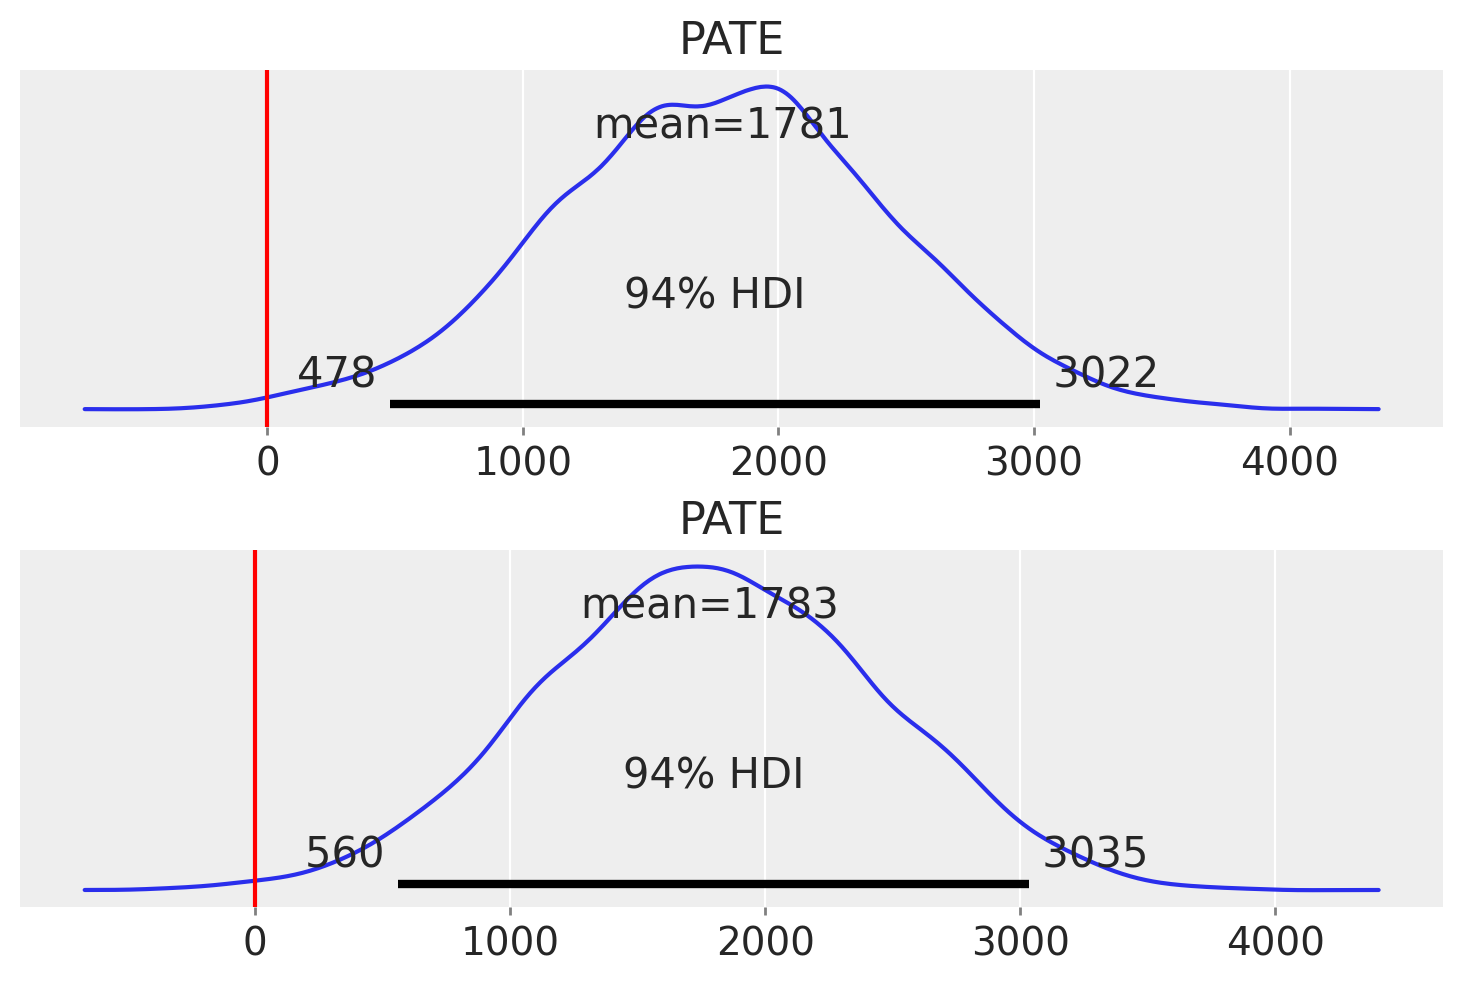

In [12]:
fig, axes = plt.subplots(2,1)
az.plot_posterior(trace.posterior['PATE'], ax=axes[0])
axes[0].axvline(x=0, color='red')
az.plot_posterior(trace_another.posterior['PATE'], ax=axes[1])
axes[1].axvline(x=0, color='red')

# 頻度論的結果

In [13]:
np.mean(df.loc[df['treatment']==1, 'RE78']) - np.mean(df.loc[df['treatment']==0, 'RE78'])

1794.342404270271

<Axes: >

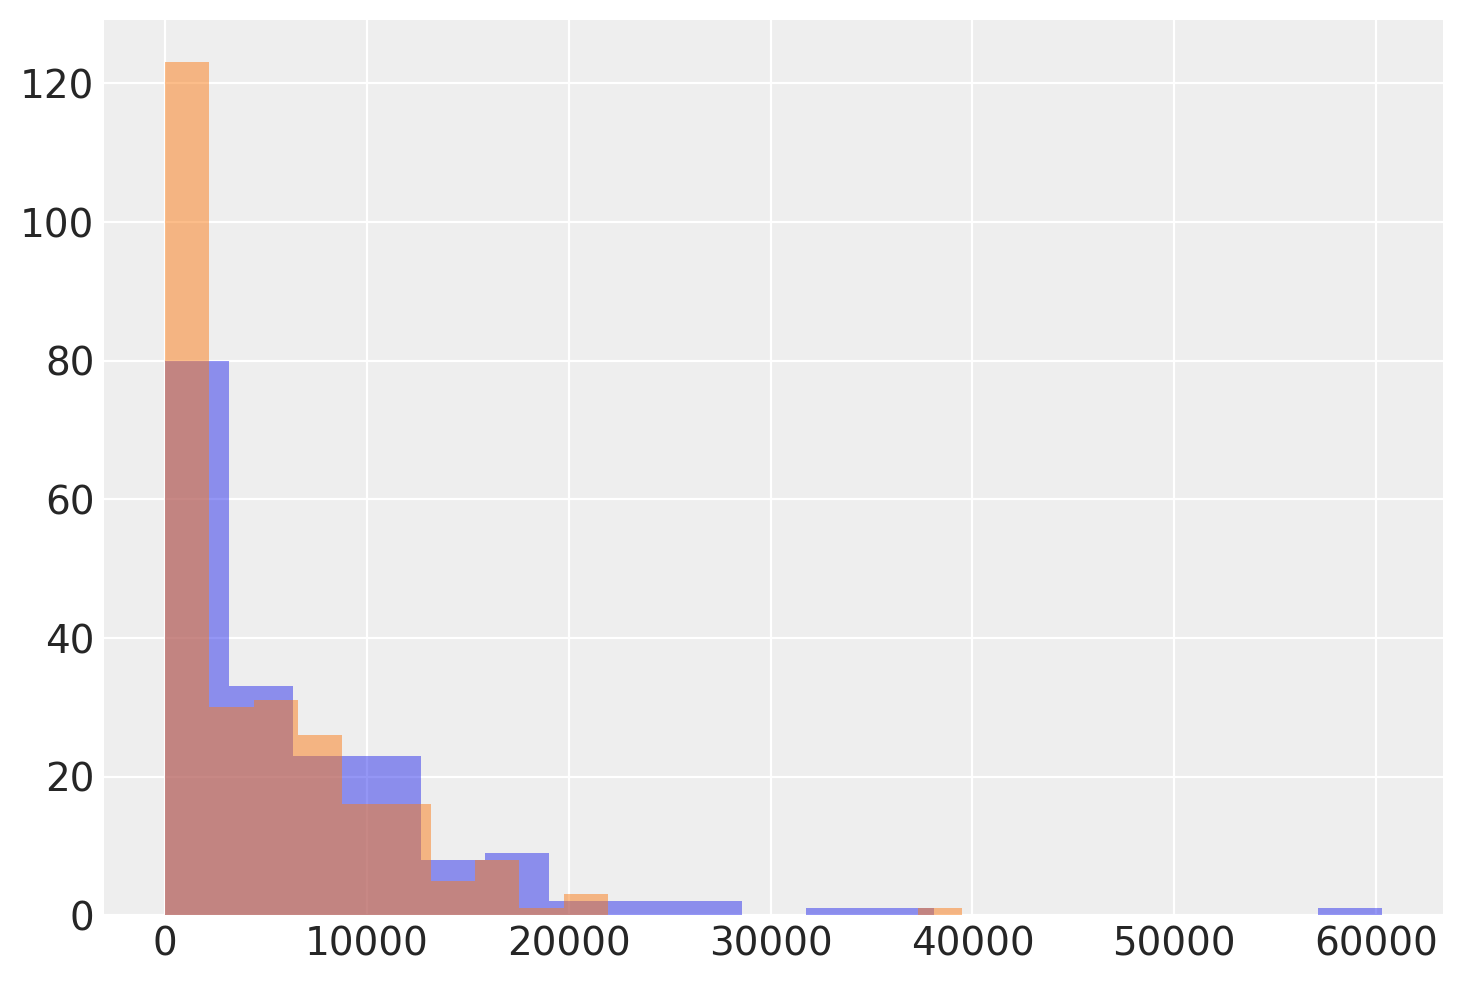

In [14]:
df.loc[df['treatment']==1, 'RE78'].hist(alpha=0.5, bins='auto')
df.loc[df['treatment']==0, 'RE78'].hist(alpha=0.5, bins='auto')

# 解析解 PATE

$$\begin{pmatrix}\mathrm{Y}_i(0) \\ \mathrm{Y}_i(1) \end{pmatrix} | \theta 
\:\sim \:
\mathcal{N}
(\begin{pmatrix} \mu_c \\ \mu_t \end{pmatrix}, \begin{pmatrix} 10,000^2 & 0 \\ 0 & 8,000^2 \end{pmatrix})$$

$$
\begin{pmatrix}
\mu_c \\ \mu_t
\end{pmatrix}
\:\sim \:
\mathcal{N}
(\begin{pmatrix} 0 \\ 0 \end{pmatrix}, \begin{pmatrix} 10,000^2 & 0 \\ 0 & 10,000^2 \end{pmatrix})
$$

$$
\begin{align}
&\begin{pmatrix}\mu_c \\ \mu_t \end{pmatrix} | \mathbf{Y}^{obs}, \mathbf{W} \\
&\:\sim \:
\mathcal{N} 
\left(\begin{pmatrix} \bar{Y}^{obs}_c\cdot\frac{N_c\cdot100,000,000}{N_c\cdot100,000,000 + 100,000,000} \\ \bar{Y}^{obs}_t\cdot\frac{N_t\cdot100,000,000}{N_t\cdot100,000,000 + 64,000,000} \end{pmatrix},
\begin{pmatrix} \frac{1}{N_c/100,000,000 + 1/100,000,000} & 0 \\ 0 & \frac{1}{N_t/64,000,000 + 1/100,000,000}\end{pmatrix}\right) \\
&\:\sim \:
\mathcal{N} 
\left(\begin{pmatrix} \mu_{\mu_c} \\ \mu_{\mu_t} \end{pmatrix},
\begin{pmatrix} \sigma_{\mu_c}^2 & 0 \\ 0 & \sigma_{\mu_t}^2 \end{pmatrix}\right)
\end{align}$$

In [15]:
mu_muc = np.mean(df_c['RE78']) * df_c.shape[0]*100000000/(df_c.shape[0]*100000000+100000000)
mu_mut = np.mean(df_t['RE78']) * df_t.shape[0]*100000000/(df_t.shape[0]*100000000+64000000)
sigma_muc = 1 / (df_c.shape[0]/100000000 + 1/100000000)
sigma_mut = 1 / (df_t.shape[0]/64000000 + 1/100000000)

$$ 
\mu_t - \mu_c | \mathbf{Y}^{obs}, \mathbf{W} \sim 
\mathcal{N}(\mu_{\mu_t}-\mu_{\mu_c}, \quad \sigma_{\mu_c}^2 + \sigma_{\mu_t}^2 + 2\cdot 0)

In [16]:
print(f'expected PATE: {mu_mut - mu_muc}')
print(f'std of PATE: {np.sqrt(sigma_mut+sigma_muc)}')

expected PATE: 1789.9048686316119
std of PATE: 853.1676554944308


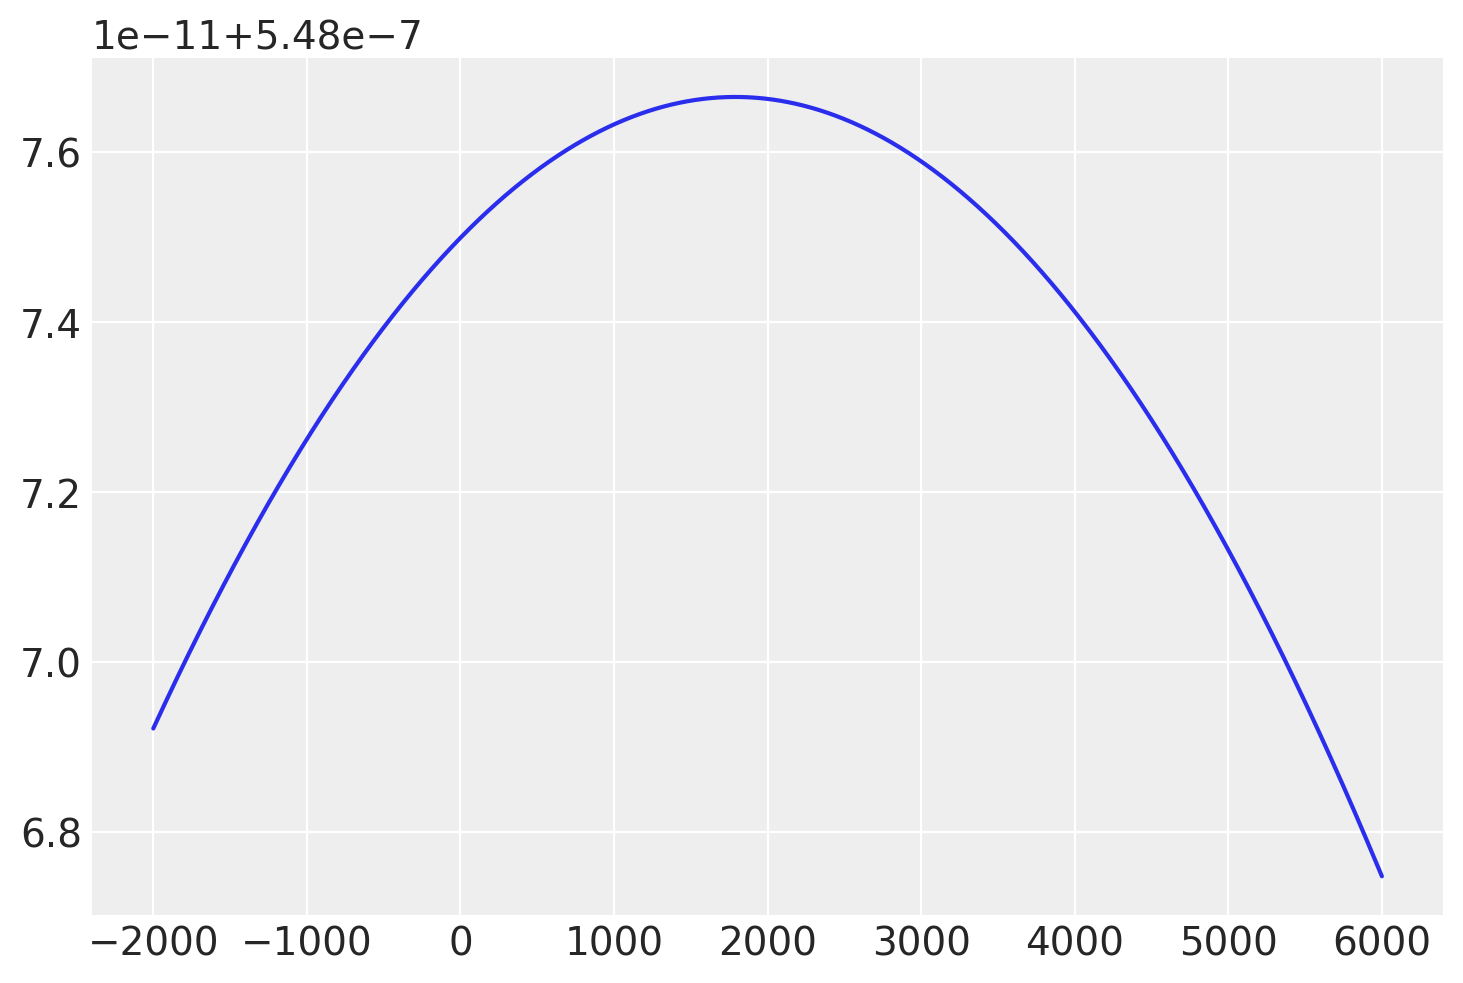

In [27]:
x = np.linspace(-2000, 6000, 1000000)
est = st.norm.pdf(x, loc=mu_mut-mu_muc, scale=sigma_mut+sigma_muc)
plt.plot(x, est)
plt.show()

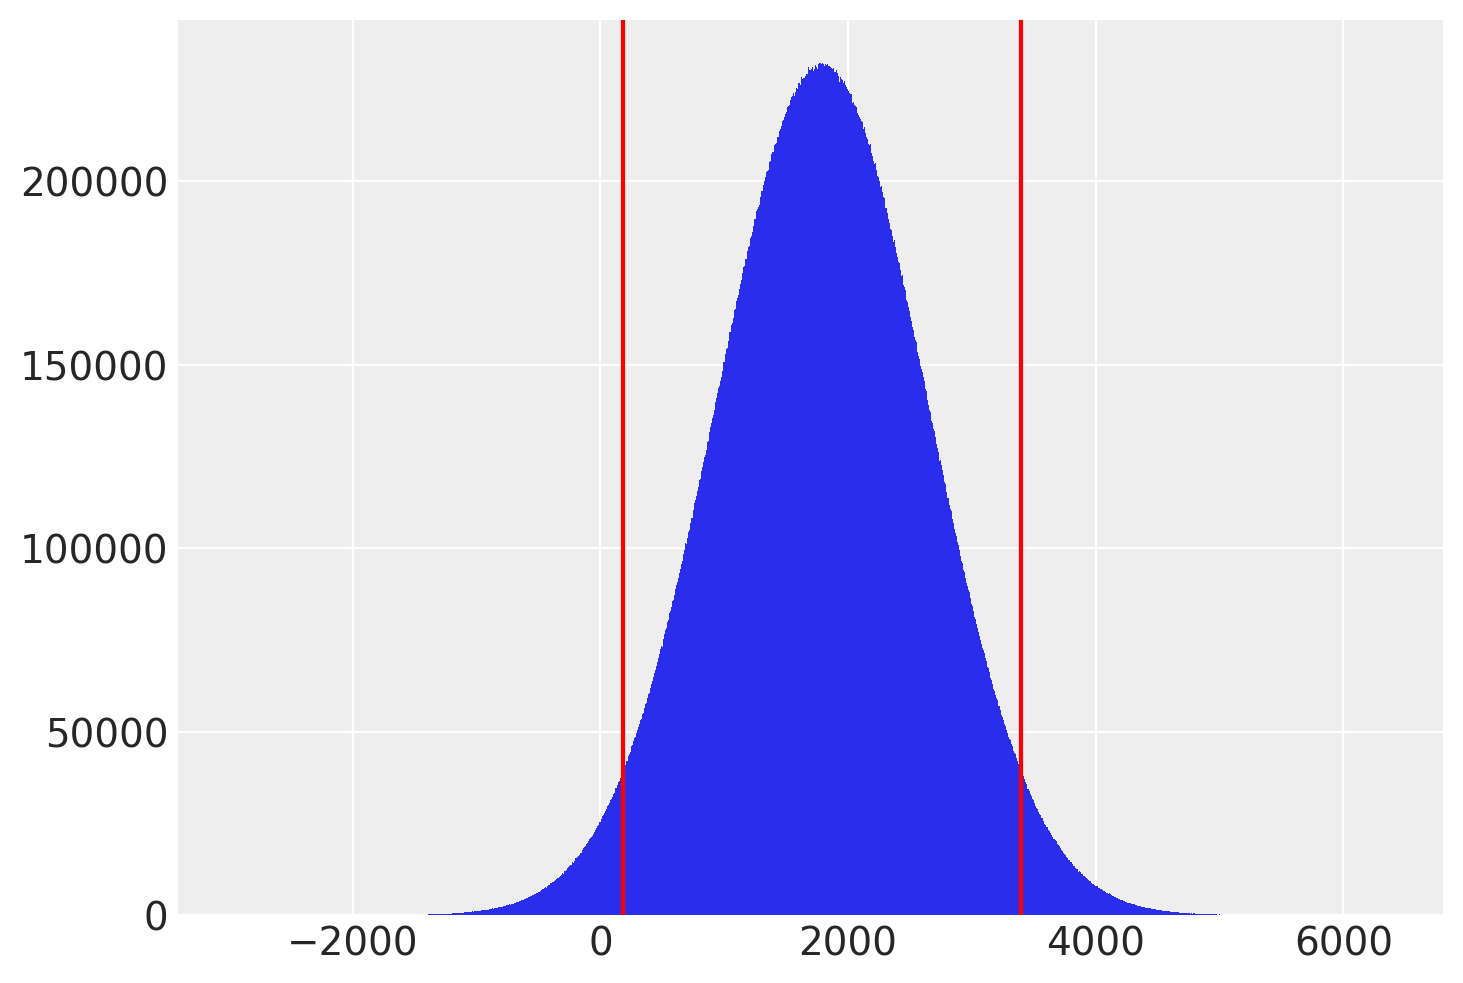

In [29]:
anlt = st.norm.rvs(loc=mu_mut-mu_muc, scale=np.sqrt(sigma_mut+sigma_muc), size=100000000, random_state=RANDOM_SEED)

plt.hist(anlt, bins='auto')
plt.axvline(x=np.quantile(anlt, [0.03, 0.97])[0], color='red')
plt.axvline(x=np.quantile(anlt, [0.03, 0.97])[1], color='red')
plt.show()

In [19]:
np.quantile(anlt, [0.03, 0.97]) # 94 % 信用区間

array([ 185.1996568 , 3394.48774895])

# おまけ

CVR の推移等、二値変数の AB テストのモデルベースな解き方を載せておきます。  
<br>
目的変数 $y$ を、CV (conversion) した数とします（商品を購入したか、サイトを訪問したか等）。  
このとき、CVR (conversion rate) を $\theta$ とし、その事前分布を Beta 分布で置きます。

$$
y_A \sim \sum^{N_A} \mathrm{Bernoulli}(\theta_A) = \mathrm{Binomial}(N_A, \theta_A)
$$
$$
y_B \sim \sum^{N_B} \mathrm{Bernoulli}(\theta_B) = \mathrm{Binomial}(N_B, \theta_B)
$$
$$
\theta_A \sim \mathrm{Beta}(\alpha, \beta)
$$
$$
\theta_B \sim \mathrm{Beta}(\alpha, \beta)
$$

最終的に B (介入)群の方が A (統制)軍よりも良いことを示す指標として、例えば以下が考えられます。
$$
\mathrm{Simple \: difference} = \theta_B - \theta_A
$$
$$
\mathrm{relative \: uplift_B} = \frac{\theta_B}{\theta_A} - 1
$$
以下で、モデルのベイズ推測をしていきます。

## モデル定義

In [20]:
@dataclass
class BetaPrior:
    alpha: float
    beta: float

@dataclass
class BinomialData:
    trials: int
    successes: int

In [21]:
class ConversionModelTwoVariant:
    def __init__(self, priors: BetaPrior):
        self.priors = priors

    def create_model(self, data: List[BinomialData]) -> pm.Model:
        trials = [d.trials for d in data]
        successes = [d.successes for d in data]
        with pm.Model() as model:
            # 事前分布
            p = pm.Beta("p", alpha=self.priors.alpha, beta=self.priors.beta, shape=2)
            # 尤度関数
            obs = pm.Binomial("y", n=trials, p=p, shape=2, observed=successes)
            # 評価項目
            simplediff = pm.Deterministic('simplediff', p[1] - p[0])
            reluplift = pm.Deterministic("reluplift_b", p[1] / p[0] - 1)
        return model

## データ作成

In [22]:
def generate_binomial_data(
    variants: List[str], true_rates: List[str], samples_per_variant: int = 100000
) -> pd.DataFrame:
    data = {}
    for variant, p in zip(variants, true_rates):
        data[variant] = bernoulli.rvs(p, size=samples_per_variant)
    agg = (
        pd.DataFrame(data)
        .aggregate(["count", "sum"])
        .rename(index={"count": "trials", "sum": "successes"})
    )
    return agg

In [23]:
# Example generated data
generate_binomial_data(["A", "B"], [0.23, 0.23])

,A,B
trials,100000,100000
successes,22966,22723


## ベイズ推測実行

In [30]:
def run_scenario_twovariant(
    variants: List[str],
    true_rates: List[float],
    samples_per_variant: int,
    prior: BetaPrior,
) -> None:
    generated = generate_binomial_data(variants, true_rates, samples_per_variant)
    data = [BinomialData(**generated[v].to_dict()) for v in variants]
    with ConversionModelTwoVariant(priors=prior).create_model(data):
        trace = pm.sample(draws=5000)
    
    true_rel_uplift = true_rates[1] / true_rates[0] - 1
    true_simple_diff = true_rates[1] - true_rates[0]

    fig, axs = plt.subplots(2, 1, figsize=(7, 7))
    az.plot_posterior(trace.posterior["reluplift_b"], ax=axs[0], **plotting_defaults)
    axs[0].set_title(f"True Rel Uplift = {true_rel_uplift:.1%}, {prior}", fontsize=10)
    axs[0].axvline(x=0, color="red")
    az.plot_posterior(trace.posterior['simplediff'], ax=axs[1], **plotting_defaults)
    axs[1].set_title(f'True Simple Diff = {true_simple_diff:.1%}, {prior}', fontsize=10)
    axs[1].axvline(x=0, color='red')
    fig.suptitle("B vs. A Rel Uplift / Simple Diff")
    return trace


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [p]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 23 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


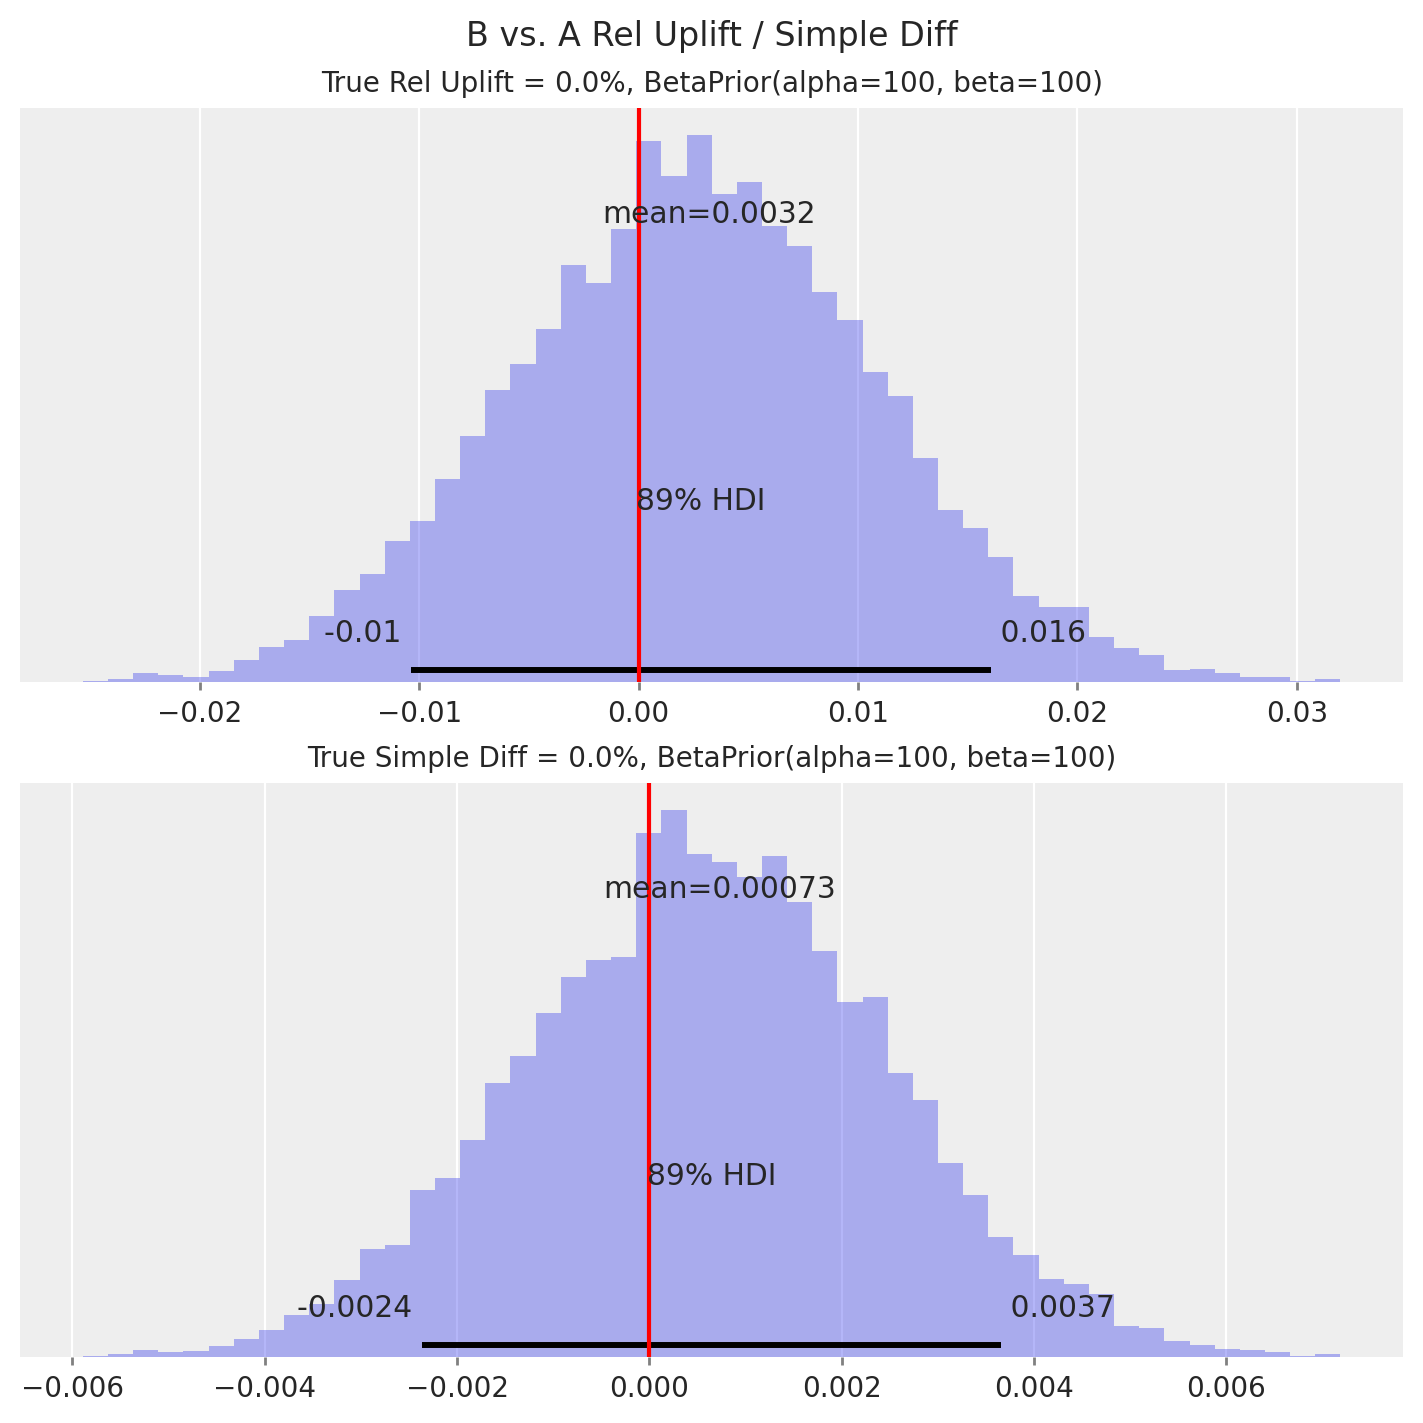

In [31]:
trace_ber = run_scenario_twovariant(
    variants=["A", "B"],
    true_rates=[0.23, 0.23],
    samples_per_variant=100000,
    prior=BetaPrior(alpha=100, beta=100)
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [p]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 25 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


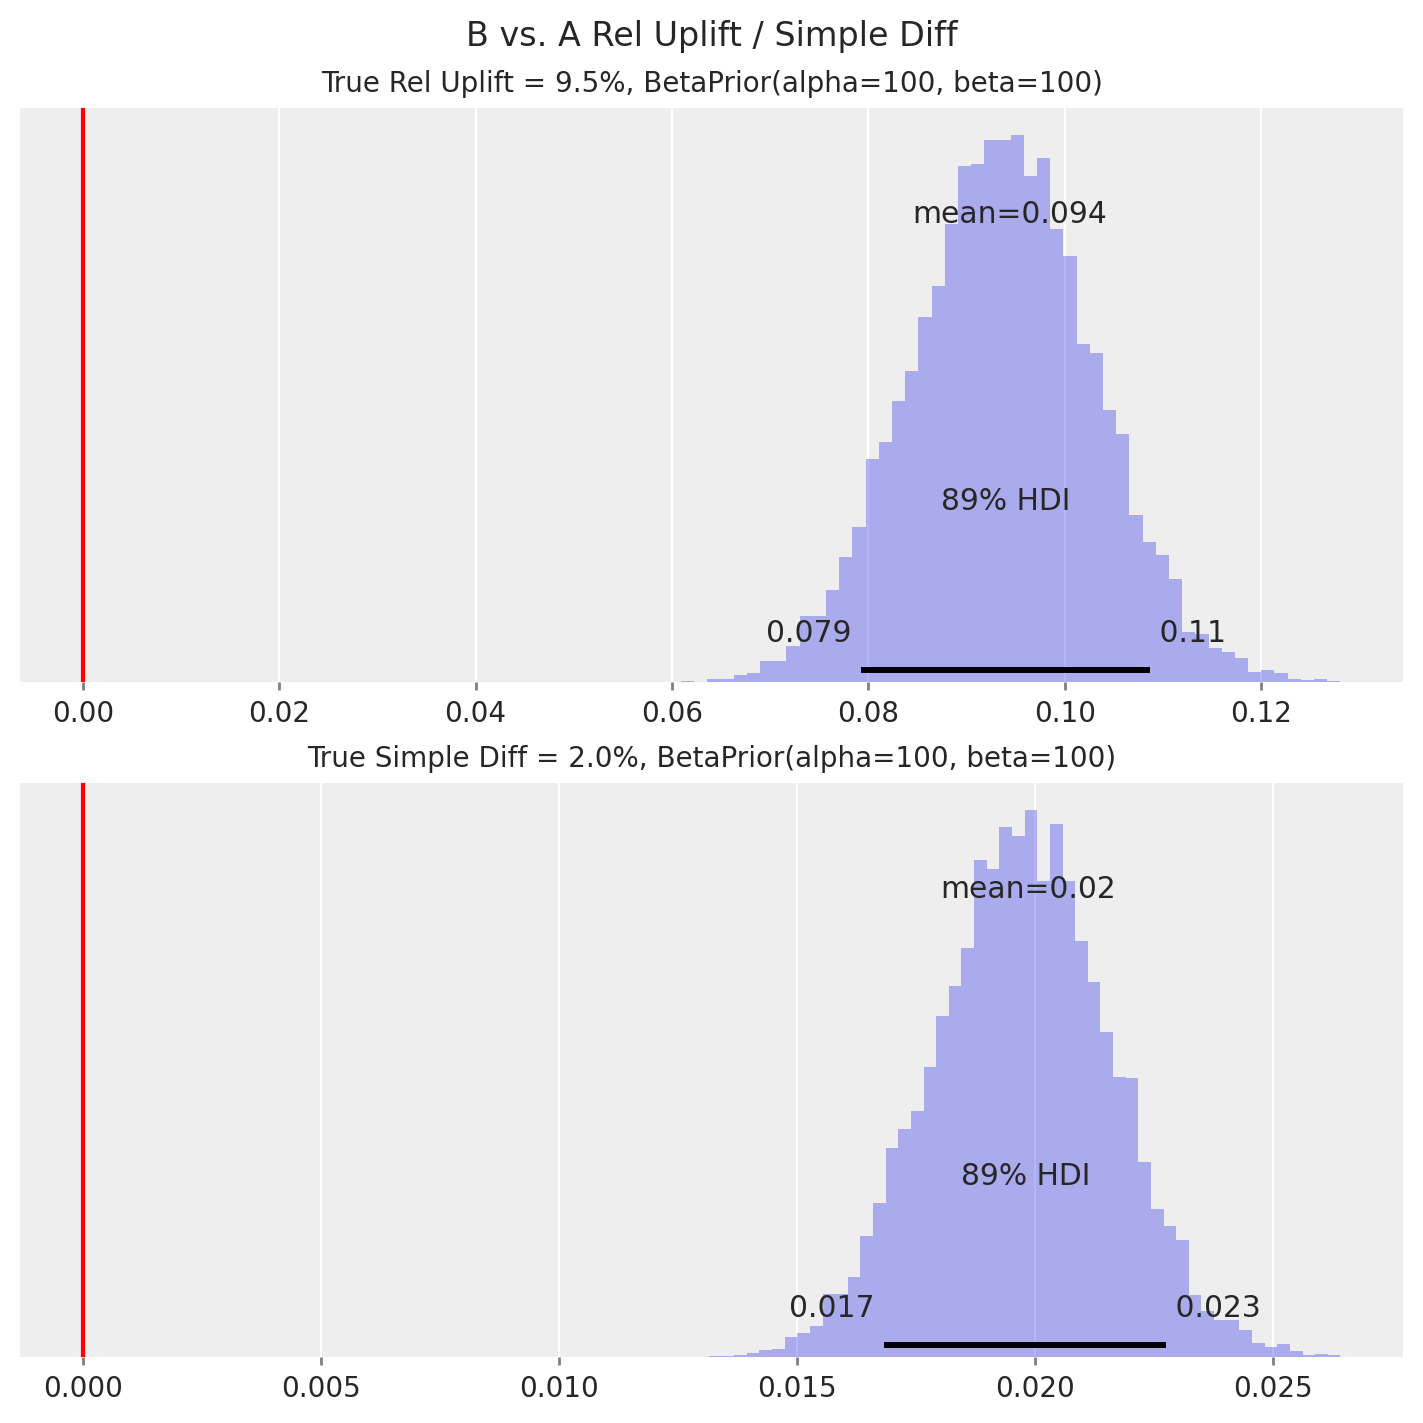

In [34]:
trace_ber2 = run_scenario_twovariant(
    variants=['A', 'B'],
    true_rates=[0.21, 0.23],
    samples_per_variant=100000,
    prior=BetaPrior(100, 100)
)